In [42]:
import numpy as np
from scipy.sparse.linalg import eigsh
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

## Задание 7 
# Задача рассеяния
## Параметры сетки и функции
Здесь задаются все требуемые при расчете параметры и функции.

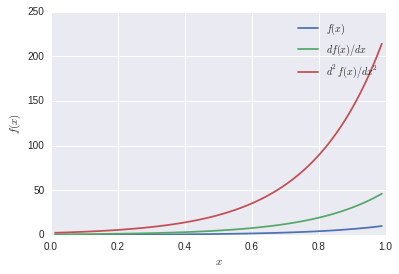

In [63]:
# равномерная сетка x \in [0,1] n=1,2,...N, N+1
N = 80
xmax = 1
h = xmax/(N+2)
xnet = np.array([h*(j+1) for j in range(N+1)])

# неравномерная сетка и её производные
f = lambda x: 0.1*(np.exp(4.651*x)-1)
df = lambda x: 0.1*4.651*np.exp(4.651*x)
d2f = lambda x: 0.1*(4.651**2)*np.exp(4.651*x)
plt.plot(xnet, f(xnet))
plt.plot(xnet, df(xnet))
plt.plot(xnet, d2f(xnet))
plt.legend(['$f(x)$', '$df(x)/dx$', '$d^2f(x)/dx^2$'])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

# потенциал
V = lambda r: -(1+1/r)*np.exp(-2*r)

# энергия и волнове число
E = 0.1
k = (2*E)**0.5

# P_s и P_c
P_s = lambda r: np.sin(k*r)
P_c = lambda r: np.cos(k*r)

## Решение задачи рассеяния методом коллокаций
Применяемый метод сводится к СЛАУ вида $A\vec{c}=\vec{b}$, где $\vec{c}$ - вектор коэффициэнтов разложения волновой функции по B-сплайнам и волне на бесконечности. Ниже формируются матрицы A и b.

In [64]:
A = np.zeros((N+3, N+3))
# первая строка
A[0, 0] = -9/2/(df(0)*h)**2 - 3*d2f(0)/2/df(0)**3/h
A[0, 1] = -3*d2f(0)/4/(df(0)**3)/h
A[0,-2] = k
A[0,-1] = -3/(df(0)*h)**2 - 3*d2f(0)/2/(df(0)**3)/h - E


# последняя строка
A[-1, 0] = 3/(df(0)*h)
A[-1, 1] = 3/(2*df(0)*h)
A[-1,-2] = k
A[-1,-1] = 3/(df(0)*h)


# диагональ
for j, x in zip(range(N+1), xnet):
    A[1+j, 1+j] = -3/2/(df(x)*h)**2 + E - V(f(x))
    A[1+j, 1+j-1] = 3/4/(df(x)*h)**2 + 3*d2f(x)/8/(df(x)**3)/h + (E - V(f(x)))/4
    A[1+j, 1+j+1] = 3/4/(df(x)*h)**2 - 3*d2f(x)/8/(df(x)**3)/h + (E - V(f(x)))/4

# предпоследний столбец
A[1:-1, -2] = [-V(f(x))*P_s(f(x)) for x in xnet]

# последний столбец
A[1:-1, -1] = [-V(f(x))*P_c(f(x)) for x in xnet]

b = np.zeros((N+3, ))
b[-1] = 1

print('A:\n',A)

A:
 [[ -1.42521989e+05  -1.32229628e+03   0.00000000e+00 ...,   0.00000000e+00
    4.47213595e-01  -9.58962901e+04]
 [  2.14456512e+04  -4.14551308e+04   2.02651598e+04 ...,   0.00000000e+00
    4.44603260e-01   1.70352877e+02]
 [  0.00000000e+00   1.91283337e+04  -3.70792519e+04 ...,   0.00000000e+00
    4.41839891e-01   8.22465059e+01]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,  -5.23765989e+00
   -8.64181467e-09  -5.62901490e-09]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   2.47519153e+00
   -3.25592995e-09  -1.12765828e-09]
 [  5.28918512e+02   2.64459256e+02   0.00000000e+00 ...,   0.00000000e+00
    4.47213595e-01   5.28918512e+02]]


In [65]:
c = np.linalg.solve(A, b)

In [66]:
print('фаза рассеяния:', np.arctan(c[-1]/c[-2]))

фаза рассеяния: 1.05327571865


Восстановление волновой функции:

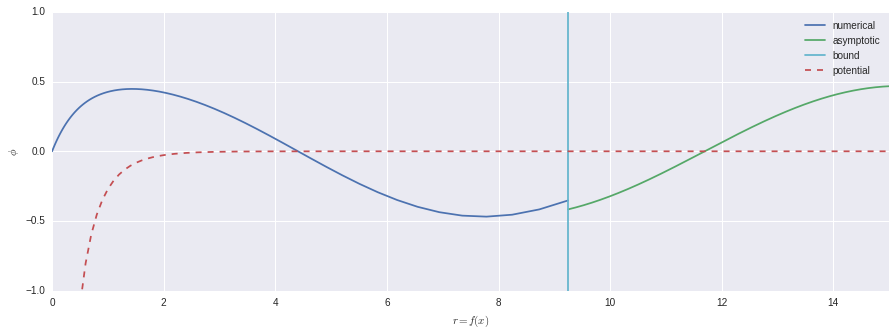

In [94]:
x = np.concatenate([[0], xnet[:-1]])
phi = c[0:-2].copy()
phi[:-1] += c[1:-2]/4
phi[1:]  += c[0:-3]/4
phi += c[-1]*P_c(f(x)) + c[-2]*P_s(f(x))
phi[0] = 0


plt.figure(figsize=(15,5))
plt.plot(f(x), phi, '-')
plt.xlabel('$r=f(x)$')
plt.ylabel('$\phi$')
plt.xlim(0,50)
plt.ylim(-1,1)
xx = np.arange(f(x).max(), 50, 0.01)
plt.plot(xx, c[-1]*P_c(xx) + c[-2]*P_s(xx))
plt.axvline(f(x).max(), color=sns.color_palette()[5])
plt.plot(np.arange(0.4, 50, 0.1), V(np.arange(0.4, 50, 0.1)), '--')
plt.legend(['numerical', 'asymptotic', 'bound','potential'])